In [ ]:
#This python notebook will train a facemask classifier based on MobileNetV3 for face images without mask and face images with mask.
#reference: 
#https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV3-Large is 3.2% more accurate on ImageNet classification while reducing latency by 15% compared to MobileNetV2. MobileNetV3-Small is 4.6% 
#more accurate while reducing latency by 5% compared to MobileNetV2. MobileNetV3-Large detection is 25% faster at roughly the same accuracy as 
#MobileNetV2 on COCO detection. 
#MobileNetV3-Large LR-ASPP is 30% faster than MobileNetV2 R-ASPP at similar accuracy for Cityscapes segmentation.
from tensorflow.keras.applications import MobileNetV2
#from tensorflow.keras.applications import MobileNetV3Small
#from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/Yolo/Face_Mask_detection/dataset

/content/drive/MyDrive/Yolo/Face_Mask_detection/dataset


In [4]:
%cd drive/MyDrive/Yolo/Face_Mask_detection/
%pwd
%cd ..

[Errno 2] No such file or directory: 'drive/MyDrive/Yolo/Face_Mask_detection/'
/content/drive/MyDrive/Yolo/Face_Mask_detection/dataset
/content/drive/MyDrive/Yolo/Face_Mask_detection


In [10]:
%ls -la dataset/with_mask/* | wc -l
%ls -la dataset/without_mask/* | wc -l  

1116
2089


In [ ]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True, 
                help="path to input dataset")
ap.add_argument("-p", "--plot", type=str, default="plot.png", 
                help="path to output loss/accuracy plot")
ap.add_argument("-m", "--model", type=str, default="mask_detector.model",
                help="path to output face mask detector model")
#args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] -d DATASET [-p PLOT] [-m MODEL]
ipykernel_launcher.py: error: the following arguments are required: -d/--dataset


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", default='dataset', 
                help="path to input dataset")
ap.add_argument("-p", "--plot", type=str, default="plot.png", 
                help="path to output loss/accuracy plot")
ap.add_argument("-m", "--model", type=str, default="mask_detector.model",
                help="path to output face mask detector model")
#args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] [-d DATASET] [-p PLOT] [-m MODEL]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-6b9c0eb6-5e0f-4905-8f8e-210765b361b2.json


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [11]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 40
BS = 32

In [15]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(args["dataset"]))
imagePaths = list(paths.list_images("/content/drive/MyDrive/Yolo/Face_Mask_detection/dataset"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


In [16]:
print(imagePaths)

['/content/drive/MyDrive/Yolo/Face_Mask_detection/dataset/without_mask/f1591117178.6926246.png', '/content/drive/MyDrive/Yolo/Face_Mask_detection/dataset/without_mask/f160.png', '/content/drive/MyDrive/Yolo/Face_Mask_detection/dataset/without_mask/f1591117173.7340832.png', '/content/drive/MyDrive/Yolo/Face_Mask_detection/dataset/without_mask/f1591117208.1580288.png', '/content/drive/MyDrive/Yolo/Face_Mask_detection/dataset/without_mask/f1591117237.3738346.png', '/content/drive/MyDrive/Yolo/Face_Mask_detection/dataset/without_mask/f1591117219.175926.png', '/content/drive/MyDrive/Yolo/Face_Mask_detection/dataset/without_mask/f1591117209.9612467.png', '/content/drive/MyDrive/Yolo/Face_Mask_detection/dataset/without_mask/f1591117191.969745.png', '/content/drive/MyDrive/Yolo/Face_Mask_detection/dataset/without_mask/f1591117242.277863.png', '/content/drive/MyDrive/Yolo/Face_Mask_detection/dataset/without_mask/f1591117204.5498383.png', '/content/drive/MyDrive/Yolo/Face_Mask_detection/dataset/

In [17]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
#$ python  train_mask_detector.py --dataset  dataset 
#[INFO] loading images...
#-> (trainX, testX, trainY, testY) = train_test_split(data, labels,
#(Pdb) labels[500:]
#array([[1., 0.],
#       [1., 0.],
#       [1., 0.],
#       ...,
#       [0., 1.],
#       [0., 1.],
#       [0., 1.]], dtype=float32)
#(Pdb)

In [18]:
# load the MobileNetV3 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
#baseModel = MobileNetV3Small(weights="imagenet", include_top=False,
#	input_tensor=Input(shape=(224, 224, 3)))
#baseModel = MobileNetV3Large(weights="imagenet", include_top=False,
#	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [19]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/40
80/80 [==============================] - 134s 2s/step - loss: 0.7167 - accuracy: 0.6211 - val_loss: 0.3615 - val_accuracy: 0.8768
Epoch 2/40
80/80 [==============================] - 130s 2s/step - loss: 0.3962 - accuracy: 0.8314 - val_loss: 0.2769 - val_accuracy: 0.8955
Epoch 3/40
80/80 [==============================] - 130s 2s/step - loss: 0.3125 - accuracy: 0.8638 - val_loss: 0.2450 - val_accuracy: 0.9095
Epoch 4/40
80/80 [==============================] - 130s 2s/step - loss: 0.2910 - accuracy: 0.8707 - val_loss: 0.2293 - val_accuracy: 0.9095
Epoch 5/40
80/80 [==============================] - 131s 2s/step - loss: 0.2709 - accuracy: 0.8826 - val_loss: 0.2200 - val_accuracy: 0.9158
Epoch 6/40
80/80 [==============================] - 130s 2s/step - loss: 0.2386 - accuracy: 0.8987 - val_loss: 0.2079 - val_accuracy: 0.9189
Epoch 7/40
80/80 [==============================] - 131s 2s/step - loss: 0.2407 - accuracy: 0.8884 - val

In [20]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
# serialize the model to disk
print("[INFO] saving mask detector model...")
#model.save(args["model"], save_format="h5")
model.save("mobilenetv2_mask_detector.model", save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.98      0.88      0.92       223
without_mask       0.94      0.99      0.96       418

    accuracy                           0.95       641
   macro avg       0.96      0.93      0.94       641
weighted avg       0.95      0.95      0.95       641

[INFO] saving mask detector model...


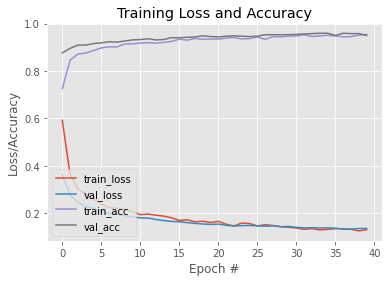

In [21]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])
plt.savefig("plot,png")

In [22]:
# Converts the Keras model to TensorFlow Lite
import tensorflow.lite as lite

input_file = "mobilenetv2_mask_detector.model"
output_file = "/content/drive/MyDrive/Yolo/Face_Mask_detection/mobilenetv2_mask_detector.tflite"

#converter = lite.TocoConverter.from_keras_model_file(input_file)
#converter = lite.TFLiteConverter.from_saved_model(input_file)
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(output_file, "wb").write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpzu0mjh3v/assets


9515960

In [ ]:
%ls

darknet/                          plot,png.png           yolo_data.cache
dataset/                          README.md              yolov4-csp/
Face_Mask_data/                   README_pix/            yolov4-csp.ipynb
mobilenetv2_mask_detector.model   xml_covert_to_yolo.py
mobilenetv2_mask_detector.tflite  yolo_data/


In [ ]:
# import the necessary packages
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

In [ ]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to input image")
ap.add_argument("-f", "--face", type=str,
	default="face_detector",
	help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
#args = vars(ap.parse_args())

In [ ]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
#prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
#weightsPath = os.path.sep.join([args["face"],
#	"res10_300x300_ssd_iter_140000.caffemodel"])
#net = cv2.dnn.readNet(prototxtPath, weightsPath)
# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model("facemask_classifier.h5") #args["model"])

In [ ]:
# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread(args["image"])
orig = image.copy()
(h, w) = image.shape[:2]
# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))
# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

In [ ]:
# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]
	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > args["confidence"]:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

In [ ]:
	# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)
		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model.predict(face)[0]

In [ ]:
		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
# show the output image
cv2.imshow("Output", image)
cv2.waitKey(0)

In [ ]:
$ python detect_mask_image.py --image examples/example_01.png 
[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...

In [ ]:
$ python detect_mask_image.py --image examples/example_02.png 
[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...

In [ ]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

In [ ]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))
	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

In [ ]:
# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]
		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > args["confidence"]:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")
			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

In [ ]:
			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

In [ ]:
# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)
	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

In [ ]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--face", type=str,
	default="face_detector",
	help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

In [ ]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model(args["model"])
# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

In [ ]:
# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=400)
	# detect faces in the frame and determine if they are wearing a
	# face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

In [ ]:
	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred
		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

In [ ]:
# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF
	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

In [ ]:
$ python detect_mask_video.py
[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] starting video stream...